In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math

In [2]:
# 成人问卷
df1=pd.read_sas('CFPS2016/cfps2016adult_201906.sas7bdat')
df1['pid']=df1['pid'].astype(int)
# 家庭成员关系
# 需要从中识别父亲编号pid_f，再去成人问卷中匹配父亲pid
df2=pd.read_sas('CFPS2016/cfps2016famconf_201804.sas7bdat')
df2[['pid','pid_f']]=df2[['pid','pid_f']].astype(int)

In [34]:
# 个人库
df1

,pid,CODE_A_P,fid16,fid14,fid12,fid10,subsample,subpopulation,RSWT_NATCS16,RSWT_RESCS16,...,PZ211,PZ5,CESD20sc,incomeb_imp,cfps2016edu,cfps2016sch,cfps2016eduy,cfps2016eduy_im,Interviewerid,ReleaseVersion
0,100051501,501.0,100051.0,100051.0,-8.0,-8.0,1.0,6.0,NaN,NaN,...,NaN,NaN,28.0,12080.0,4.0,4.0,12.0,12.0,10840.0,2.2
1,100051502,502.0,100051.0,100051.0,-8.0,-8.0,1.0,6.0,NaN,NaN,...,NaN,NaN,32.0,43455.0,4.0,4.0,12.0,12.0,10840.0,2.2
2,100810551,551.0,100810.0,-8.0,-8.0,-8.0,1.0,6.0,NaN,NaN,...,NaN,NaN,42.0,-8.0,3.0,3.0,9.0,9.0,10840.0,2.2
3,101129501,501.0,101129.0,101129.0,-8.0,-8.0,1.0,6.0,NaN,NaN,...,NaN,NaN,26.0,-8.0,2.0,3.0,9.0,9.0,11226.0,2.2
4,101581553,553.0,101581.0,-8.0,-8.0,-8.0,1.0,6.0,NaN,NaN,...,NaN,NaN,36.0,-8.0,5.0,5.0,15.0,15.0,10840.0,2.2
5,102438551,551.0,102438.0,-8.0,-8.0,-8.0,0.0,2.0,NaN,NaN,...,NaN,NaN,40.0,-8.0,4.0,4.0,12.0,12.0,10690.0,2.2
6,102571551,551.0,102571.0,-8.0,-8.0,-8.0,0.0,2.0,NaN,NaN,...,NaN,NaN,26.0,-8.0,NaN,NaN,NaN,NaN,11059.0,2.2
7,102571552,552.0,102571.0,-8.0,-8.0,-8.0,0.0,2.0,NaN,NaN,...,NaN,NaN,34.0,-8.0,NaN,NaN,NaN,NaN,11059.0,2.2
8,103465551,551.0,103465.0,-8.0,-8.0,-8.0,0.0,2.0,NaN,NaN,...,NaN,NaN,25.0,-8.0,6.0,6.0,16.0,16.0,11185.0,2.2
9,103788501,501.0,103788.0,103788.0,-8.0,-8.0,0.0,2.0,NaN,NaN,...,NaN,NaN,34.0,-8.0,6.0,6.0,16.0,16.0,10606.0,2.2


In [15]:
# 家庭成员关系
df2

,fid16,fid14,fid12,fid10,fid_provcd16,fid_countyid16,fid_URBAN16,pid,CODE_A_P,co_a16_p,...,familysize16,SRESPPID,KZ1PID,KZ101PID,cyear,cmonth,IWMODE,SUBPOPULATION,subsample,RELEASEVERSION
0,100051.0,100051.0,-8.0,-8.0,11.0,45.0,1.0,100051501,501.0,1.0,...,3.0,100051502.0,100051502.0,7.800000e+01,2016.0,9.0,2.0,6.0,1.0,b'1.0'
1,100051.0,100051.0,-8.0,-8.0,11.0,45.0,1.0,100051502,502.0,1.0,...,3.0,100051502.0,100051502.0,7.800000e+01,2016.0,9.0,2.0,6.0,1.0,b'1.0'
2,100376.0,-8.0,-8.0,-8.0,13.0,235.0,1.0,100376551,551.0,1.0,...,2.0,130094103.0,130094103.0,7.800000e+01,2016.0,12.0,2.0,6.0,1.0,b'1.0'
3,100435.0,-8.0,-8.0,-8.0,13.0,52.0,0.0,100435552,552.0,1.0,...,4.0,130155103.0,130155103.0,7.800000e+01,2016.0,8.0,2.0,6.0,1.0,b'1.0'
4,100453.0,100453.0,100453.0,-8.0,43.0,29.0,1.0,100453401,401.0,1.0,...,6.0,430111101.0,430111101.0,7.800000e+01,2016.0,12.0,1.0,6.0,1.0,b'1.0'
5,100453.0,100453.0,100453.0,-8.0,43.0,29.0,1.0,100453431,431.0,1.0,...,6.0,430111101.0,430111101.0,7.800000e+01,2016.0,12.0,1.0,6.0,1.0,b'1.0'
6,100453.0,-8.0,-8.0,-8.0,43.0,29.0,1.0,100453551,551.0,1.0,...,6.0,430111101.0,430111101.0,7.800000e+01,2016.0,12.0,1.0,6.0,1.0,b'1.0'
7,100551.0,-8.0,-8.0,-8.0,13.0,363.0,1.0,100551551,551.0,1.0,...,3.0,130281103.0,130281103.0,7.800000e+01,2016.0,9.0,1.0,6.0,1.0,b'1.0'
8,100551.0,-8.0,-8.0,-8.0,13.0,363.0,1.0,100551552,552.0,1.0,...,3.0,130281103.0,130281103.0,7.800000e+01,2016.0,9.0,1.0,6.0,1.0,b'1.0'
9,100810.0,-8.0,-8.0,-8.0,13.0,48.0,1.0,100810551,551.0,1.0,...,3.0,130547103.0,130547103.0,1.008106e+08,2016.0,9.0,2.0,6.0,1.0,b'1.0'


In [3]:
# describe后发现id有为负数的，视作异常样本
# df1剔除id不在区间范围的记录
# 删除4条
out_df1=np.where((df1.pid<100051501)|(df1.pid>2489151502))[0]
df1.drop(out_df1,inplace=True)
df1.reset_index(drop=True,inplace=True)

In [4]:
# df2剔除pid_f等于-8和77的样本的记录
# 删除32844
out_df2=np.where((df2.pid<100051501)|(df2.pid>2845312554))[0] # 查看后没有记录
index1=np.where((df2.pid_f==-8)|(df2.pid_f==77))[0]
df2_1=df2.drop(list(out_df2)+list(index1))
df2_1.reset_index(drop=True,inplace=True)
# 筛选所需变量
df2_2=df2_1[['pid','pid_f','co_a16_p','co_a16_f','tb6_a16_p','tb6_a16_f','alive_a16_p','alive_a16_f']]

In [23]:
# 查看有无id重复记录
df1[df1.pid.duplicated(keep=False)]
df2_2[df2_2[['pid','pid_f']].duplicated(keep=False)]

,pid,pid_f,co_a16_p,co_a16_f,tb6_a16_p,tb6_a16_f,alive_a16_p,alive_a16_f


In [5]:
# 进行从个人库中匹配子代的相关信息
# 成人库中选取相关变量
df1_1=df1[['pid','provcd16','urban16','CFPS_AGE','CFPS_GENDER','CFPS_LATEST_EDU','PA301',
          'SCHOOL','EMPLOY','QG101','qg303code_isei','qg303code_siops','INCOMEB','INCOMEA',
           'INCOME','QN4001','incomeb_imp','cfps2016edu','cfps2016eduy','cfps2016eduy_im']]

In [6]:
# 数据匹配，需要匹配两次，分别获取个人详细信息和父亲详细信息
# 获取个人信息
merge1=pd.merge(df1_1,df2_2,on='pid')
merge1.rename(columns={'pid_f':'fpid'},inplace=True)# 避免merge产生重复列
# 获取父亲信息
merge2=pd.merge(merge1,df1_1,left_on='fpid',right_on='pid',suffixes=['_p','_f'])
merge2.drop(['fpid'],axis=1,inplace=True)
# 将列名全改为小写，方便后续操作
for x in merge2.columns.values:
    merge2.rename(columns={x:x.lower()},inplace=True)
# 匹配了9557
merge2.head()

,pid_p,provcd16_p,urban16_p,cfps_age_p,cfps_gender_p,cfps_latest_edu_p,pa301_p,school_p,employ_p,qg101_p,...,qg303code_isei_f,qg303code_siops_f,incomeb_f,incomea_f,income_f,qn4001_f,incomeb_imp_f,cfps2016edu_f,cfps2016eduy_f,cfps2016eduy_im_f
0,108660552,41.0,1.0,43.0,1.0,-8.0,1.0,0.0,1.0,1.0,...,NaN,NaN,-8.0,NaN,-8.0,1.0,-8.0,1.0,0.0,0.0
1,109137501,41.0,1.0,31.0,1.0,4.0,3.0,0.0,1.0,5.0,...,51.0,45.0,-8.0,0.0,-8.0,0.0,39297.0,4.0,12.0,12.0
2,110003103,11.0,1.0,19.0,0.0,3.0,1.0,5.0,1.0,5.0,...,70.0,70.0,-8.0,0.0,-8.0,0.0,NaN,4.0,12.0,12.0
3,110006103,11.0,1.0,26.0,0.0,3.0,3.0,0.0,3.0,5.0,...,67.0,63.0,-8.0,0.0,-8.0,1.0,48290.0,3.0,11.0,11.0
4,110009107,11.0,1.0,28.0,1.0,6.0,3.0,0.0,1.0,5.0,...,NaN,NaN,-8.0,-8.0,-8.0,0.0,-8.0,1.0,NaN,6.0


In [7]:
# 筛选子辈年龄16-45,父辈年龄38-65,父子年龄差小于16(异常样本) 暂定这个范围
res1=merge2
index2=np.where((res1.cfps_age_p<16)|(res1.cfps_age_p>45))[0]
index3=np.where((res1.cfps_age_f<38)|(res1.cfps_age_f>65))[0]
res1['age_dif']=res1['cfps_age_f']-res1['cfps_age_p']
index4=np.where(res1['age_dif']<16)[0]
res2=res1.drop(list(index2)+list(index3)+list(index4))
# 剩余7821
res2.reset_index(drop=True,inplace=True)

In [8]:
# 筛选已离开学校，且有工作的样本school=0,employ=1，不要在职学生的数据（数据量比较小，且收入误差可能较大）
# school employ
# 注意需要用& |,用and,or会报错,&的优先级比==高,
index5=np.where((res2.school_p==0) & (res2.employ_p==1))[0]
res3=res2.loc[index5,:]
# 剩余4309
res3.reset_index(drop=True,inplace=True)

In [9]:
# 由于操作不当，2014-2016两次调查间主要工作未发生变动的人群的主要工作数据未采集成功，通过模型进行了插补
# 如果主要工作收入incomeb=-8缺失，需要看是否有incomeb_imp
# 考虑使用总收入income，因为有些一般工作收入incomea>incomeb，需要全面考虑,income=incomea+incomeb
# 计算前先剔除incomea=-9（缺失）,incomea=-8时取0，income=incomeb
res3['incomeb_adj_p']=res3.apply(lambda x:x['incomeb_imp_p'] if x['incomeb_p']==-8 else x['incomeb_p'],axis=1)
res3['incomeb_adj_f']=res3.apply(lambda x:x['incomeb_imp_f'] if x['incomeb_f']==-8 else x['incomeb_f'],axis=1)
res3.drop(['incomeb_p','incomeb_f'],axis=1,inplace=True)
res3.rename(columns={'incomeb_adj_p':'incomeb_p','incomeb_adj_f':'incomeb_f'},inplace=True)
res3.reset_index(drop=True,inplace=True)
index6=np.where((res3.incomea_p==-9)|(res3.incomea_f==-9))[0]
res3.drop(index6,inplace=True)
res3.reset_index(drop=True,inplace=True)
res3['income_p']=res3.apply(lambda x:x['incomea_p']+x['incomeb_p'] if x['incomea_p']!=-8 else x['incomeb_p'],axis=1)
res3['income_f']=res3.apply(lambda x:x['incomea_f']+x['incomeb_f'] if x['incomea_f']!=-8 else x['incomeb_f'],axis=1)

In [10]:
# 剔除收入为空，或为-8,0的样本数据，以income为标准
res4=res3.dropna(subset=['income_p','income_f']).reset_index(drop=True) # 剔除缺失值
index7=np.where((res4['income_p'].isin([-8,0]))|(res4['income_f'].isin([-8,0])))[0] # 剔除收入不适用和为0的数据
res5=res4.drop(index7) # 剩1105
res5.reset_index(drop=True,inplace=True)

In [11]:
# 查看学历是否需要插补
# 若教育年限缺失，看是否能用插补值；若最高学历缺失，考虑用最近一次调查的最高学历
# 注意插补后有为-8和空的，后续记得剔除
res6=res5.copy()
res6['cfps2016eduy_p']=res6.apply(lambda x:x['cfps2016eduy_im_p'] if np.isnan(x['cfps2016eduy_p']) else x['cfps2016eduy_p'],axis=1)
res6['cfps2016eduy_f']=res6.apply(lambda x:x['cfps2016eduy_im_f'] if np.isnan(x['cfps2016eduy_f']) else x['cfps2016eduy_f'],axis=1)
res6['cfps2016edu_p']=res6.apply(lambda x:x['cfps_latest_edu_p'] if np.isnan(x['cfps2016edu_p']) else x['cfps2016edu_p'],axis=1)
res6['cfps2016edu_f']=res6.apply(lambda x:x['cfps_latest_edu_f'] if np.isnan(x['cfps2016edu_f']) else x['cfps2016edu_f'],axis=1)

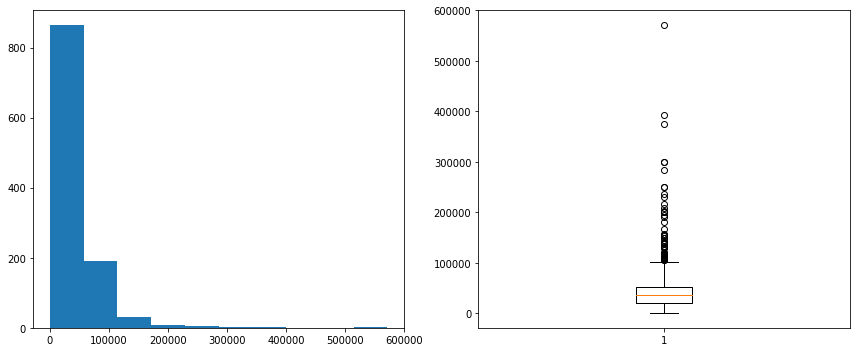

In [12]:
# 子代收入分布情况
fig_p = plt.figure(figsize=(12,5))
ax1_p = fig_p.add_subplot(121)
ax2_p=fig_p.add_subplot(122)
ax1_p.hist(res6['income_p'],bins=10)
ax2_p.boxplot(res6['income_p'])
fig_p.tight_layout()
plt.show()

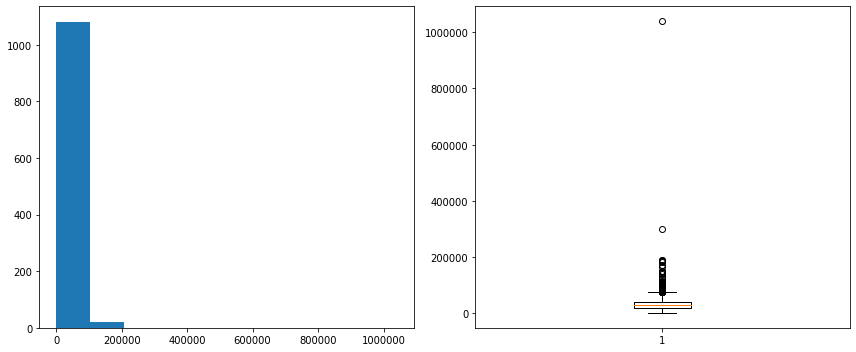

In [13]:
# 父代收入分布情况
fig_f = plt.figure(figsize=(12,5))
ax1_f = fig_f.add_subplot(121)
ax2_f=fig_f.add_subplot(122)
ax1_f.hist(res6['income_f'],bins=10)
ax2_f.boxplot(res6['income_f'])
fig_f.tight_layout()
plt.show()

In [14]:
# 计算收入的分位数
tmp_inp=np.array(res6['income_p'])
tmp_inf=np.array(res6['income_f'])
per_p=[np.percentile(tmp_inp,x) for x in [100,99,95,90,75,50,25,10,5,1,0]]
per_f=[np.percentile(tmp_inf,x) for x in [100,99,95,90,75,50,25,10,5,1,0]]
col_name=['100%max','99%','95%','90%','75%','50%','25%','10%','5%','1%','0%min']
pd.DataFrame([per_p,per_f],columns=col_name)

,100%max,99%,95%,90%,75%,50%,25%,10%,5%,1%,0%min
0,572000.0,209146.36,108739.6,77926.4,52973.0,35673.0,20000.0,8511.2,4400.0,1500.0,1.0
1,1040000.0,145485.12,74845.4,60000.0,41754.0,29760.0,18974.0,8955.4,5713.6,3000.0,700.0


In [15]:
# 剔除首尾1%的极端数据，60条
index8=np.where((res6.income_p<=np.percentile(tmp_inp,1))|(res6.income_p>=np.percentile(tmp_inp,99))|
               (res6.income_f<=np.percentile(tmp_inf,1))|(res6.income_f>=np.percentile(tmp_inf,99)))[0]
res7=res6.drop(index8)# 剩1045
res7.reset_index(drop=True,inplace=True)

In [16]:
# 根据其他相关变量剔除样本，包括缺失、不适用等
res8=res7.dropna(subset=['provcd16_p','provcd16_f','urban16_p','urban16_f',
                         'qg303code_isei_p','qg303code_isei_f','cfps2016edu_p','cfps2016edu_f',
                        'qn4001_p','qn4001_f']).reset_index(drop=True)
index9=np.where((res8.urban16_p==-9)|(res8.urban16_f==-9)|(res8.pa301_p.isin([-1,-2]))|(res8.pa301_f.isin([-1,-2]))|
            (res8.cfps2016edu_p==-8)|(res8.cfps2016edu_f==-8)|
            res8.pa301_f.isin([-1,-2])|res8.pa301_f.isin([-1,-2])|
            res8.qn4001_p.isin([-1,-9])|res8.qn4001_f.isin([-1,-9]))[0]
res8.drop(index9,inplace=True)
res8.reset_index(drop=True,inplace=True)# 剩943

In [18]:
res8.groupby('provcd16_p')['pid_p'].size()

provcd16_p
11.0     16
12.0      7
13.0     48
14.0     41
15.0      1
21.0     85
22.0     17
23.0     19
31.0     81
32.0     43
33.0     42
34.0     22
35.0     13
36.0     20
37.0     46
41.0     83
42.0     11
43.0     20
44.0    128
45.0     15
46.0      2
50.0      8
51.0     35
52.0     11
53.0     12
61.0     25
62.0     87
63.0      1
65.0      4
Name: pid_p, dtype: int64

In [37]:
# 计算收入阶层
def per_num(x,tmp):
    '''
    x:income
    tmp:array(income)
    '''
    if x<=np.percentile(tmp,20):
        return 1
    elif np.percentile(tmp,20)<x<=np.percentile(tmp,40):
        return 2
    elif np.percentile(tmp,40)<x<=np.percentile(tmp,60):
        return 3
    elif np.percentile(tmp,60)<x<=np.percentile(tmp,80):
        return 4
    else:
        return 5

res8['rank_p']=res8['income_p'].map(lambda x:per_num(x,tmp_inp))
res8['rank_f']=res8['income_f'].map(lambda x:per_num(x,tmp_inf))
# 收入阶层流动
res8['rank_flow']=res8.apply(lambda x:1 if x['rank_p']>x['rank_f'] else (-1 if x['rank_p']<x['rank_f'] else 0),axis=1)

In [22]:
res8.groupby('rank_p')['pid_p'].size()

rank_p
1    175
2    214
3    176
4    199
5    179
Name: pid_p, dtype: int64

In [25]:
res8.groupby('rank_f')['pid_f'].size()

rank_f
1    168
2    200
3    194
4    209
5    172
Name: pid_f, dtype: int64

In [38]:
res8.groupby('rank_flow').size()

rank_flow
-1    373
 0    200
 1    370
dtype: int64

In [46]:
res8[['income_p','income_f']].describe()

,income_p,income_f
count,943.000000,943.000000
mean,41511.258855,32944.683245
std,30925.380986,20148.459874
min,1800.000000,3004.000000
25%,21300.000000,19968.500000
50%,36000.000000,30000.000000
75%,52662.500000,41224.500000
max,201835.000000,144624.000000


In [47]:
res8[[]]

,pid_p,provcd16_p,urban16_p,cfps_age_p,cfps_gender_p,cfps_latest_edu_p,pa301_p,school_p,employ_p,qg101_p,...,incomeb_imp_f,cfps2016edu_f,cfps2016eduy_f,cfps2016eduy_im_f,age_dif,incomeb_p,incomeb_f,rank_p,rank_f,rank_flow
0,109137501,41.0,1.0,31.0,1.0,4.0,3.0,0.0,1.0,5.0,...,39297.0,4.0,12.0,12.0,27.0,67656.0,39297.0,5,4,1
1,110051104,11.0,1.0,30.0,0.0,4.0,3.0,0.0,1.0,5.0,...,41348.0,4.0,12.0,12.0,26.0,35140.0,41348.0,3,4,-1
2,110108103,11.0,1.0,33.0,1.0,5.0,3.0,0.0,1.0,5.0,...,38921.0,3.0,9.0,9.0,25.0,90055.0,38921.0,5,4,1
3,120009102,12.0,1.0,25.0,0.0,6.0,3.0,0.0,1.0,5.0,...,74259.0,5.0,15.0,15.0,27.0,85000.0,74259.0,5,5,0
4,120033103,12.0,0.0,26.0,1.0,5.0,1.0,0.0,1.0,5.0,...,29429.0,1.0,0.0,0.0,37.0,3602.0,29429.0,2,3,-1
5,120056103,12.0,1.0,25.0,1.0,6.0,3.0,0.0,1.0,5.0,...,-8.0,3.0,9.0,9.0,24.0,97867.0,40000.0,5,4,1
6,120109101,12.0,1.0,31.0,1.0,4.0,3.0,0.0,1.0,5.0,...,-8.0,3.0,9.0,9.0,28.0,66855.0,12000.0,5,1,1
7,120111102,12.0,1.0,32.0,1.0,5.0,3.0,0.0,1.0,5.0,...,130851.0,4.0,12.0,12.0,22.0,190000.0,130851.0,5,5,0
8,120129103,33.0,1.0,23.0,0.0,5.0,3.0,0.0,1.0,5.0,...,41329.0,3.0,9.0,9.0,25.0,45000.0,41329.0,4,4,0
9,130008103,13.0,1.0,29.0,1.0,3.0,1.0,0.0,1.0,5.0,...,18683.0,4.0,12.0,12.0,27.0,20056.0,18683.0,2,2,0
